# Analysis Notebook

In [40]:
import pandas as pd
import os
import matplotlib

os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATA = "data/clean/bike_accidents.csv"
assert os.path.exists(DATA)

df = pd.read_csv(DATA)
#df

## Questions

Do most accidents occur in intersections?

Do more or less accidents occur at *lighted* intersections?

Which roads are the most dangerous? 

What type of road is the most dangerous?

Which areas of town are the most dangerous to ride?

What time of day do accidents occur?

What day of the week do the most/least accidents occur?

What are the safest road condiditons to ride?

<Axes: xlabel='roadway_name'>

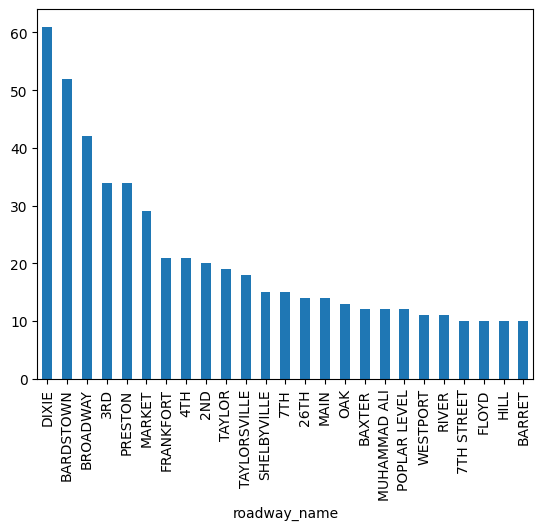

In [20]:
df['roadway_name'].value_counts().head(25).plot(kind='bar')

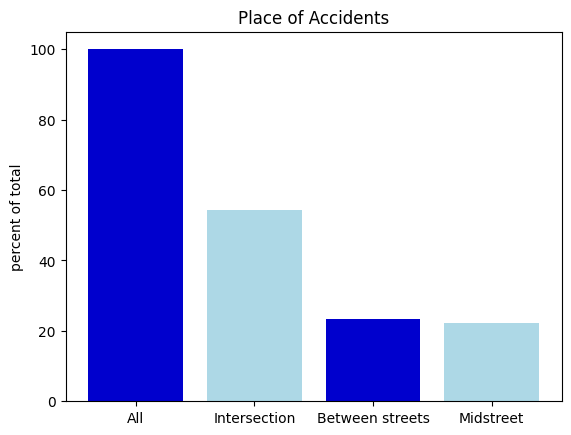

In [52]:
total = len(df)

# Find accidents that are in intersections
intersection_accidents = df[df['intersection_roadway_name'].notna() | df['intersection_roadway_number'].notna()]
# Percent of accidents that occurred in intersections
pct_intersection_accidents = (len(intersection_accidents) / total) * 100

between_street_accidents = df[df['between_street_name_1'].notna() | df['between_street_name_2'].notna()]
pct_between_accidents = (len(between_street_accidents)/total) * 100

midstreet_accidents = total - len(between_street_accidents) - len(intersection_accidents)
# TODO Might there be some overlap between intersection accidents and between street accidents somehow?
pct_midstreet_accidents = (midstreet_accidents/total) * 100

graph = matplotlib.pyplot

# x-coordinates of left sides of bars  
left = [1, 2, 3, 4] 
# heights of bars 
height = [100, pct_intersection_accidents, pct_between_accidents, pct_midstreet_accidents]
# labels for bars 
tick_label = ['All', 'Intersection', 'Between streets', 'Midstreet']
  
# plotting a bar chart 
graph.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['mediumblue', 'lightblue'])   
# naming the x-axis 
#graph.xlabel('Place of accident') 
# naming the y-axis 
graph.ylabel('percent of total') 
# plot title 
graph.title('Place of Accidents') 
  
# function to show the plot 
graph.show() 

# TODO find a way to label bars